In [17]:
import os
import sklearn
import numpy as np
from numpy import unwrap, diff, abs, angle
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from sklearn.utils import shuffle
import scipy
from scipy.signal import butter, filtfilt, hilbert
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense,  BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import mne
from mne.preprocessing import ICA
import pywt
from scipy.stats import skew, kurtosis
from scipy.signal import spectrogram
from mne.viz import plot_topomap
from scipy.signal import welch
import matplotlib.pyplot as plt

Preproccesing Functions

In [113]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def denoise_data(df, col_names, n_clusters):
    df_denoised = df.copy()
    for col_name, k in zip(col_names, n_clusters):
        df_denoised[col_name] = pd.to_numeric(df_denoised[col_name], errors='coerce') # Convert column to numeric format
        X = df_denoised.select_dtypes(include=['float64', 'int64']) # Select only numeric columns
        clf = KNeighborsRegressor(n_neighbors=k, weights='uniform') # Fit KNeighborsRegressor
        clf.fit(X.index.values[:, np.newaxis], X[col_name])
        y_pred = clf.predict(X.index.values[:, np.newaxis]) # Predict values 
        df_denoised[col_name] = y_pred
    return df_denoised

def z_score(df, col_names):
    df_standard = df.copy()
    for col in col_names:
        df_standard[col] = (df[col] - df[col].mean()) / df[col].std()
    return df_standard

def custom_detrend(df, col_names):
    df_detrended = df.copy()
    for col in col_names:
        y = df_detrended[col]
        x = np.arange(len(y))
        p = np.polyfit(x, y, 1)
        trend = np.polyval(p, x)
        detrended = y - trend
        df_detrended[col] = detrended
    return df_detrended

def preprocess(df, col_names, n_clusters):
    df_new = df.copy()
    df_new = denoise_data(df, col_names, n_clusters)
    df_new = z_score(df_new, col_names)
    # df_new = custom_detrend(df_new, col_names)
    return df_new

def df_to_raw(df, sfreq=250):
    info = mne.create_info(ch_names=list(df.columns), sfreq=sfreq, ch_types=['eeg'] * df.shape[1])
    raw = mne.io.RawArray(df.T.values * 1e-6, info)  # Converting values to Volts from microvolts for MNE
    return raw

def reject_artifacts(df, channel):
    threshold_factor = 3
    median = df[channel].median()
    mad = np.median(np.abs(df[channel] - median))
    spikes = np.abs(df[channel] - median) > threshold_factor * mad
    x = np.arange(len(df[channel]))
    cs = CubicSpline(x[~spikes], df[channel][~spikes]) # Interpolate using Cubic Spline
    interpolated_values = cs(x)
    interpolated_values[spikes] *= 0.1  # Make interpolated values 0.1 times smaller
    # Check each interpolated value's difference from median and compare to the threshold
    spike_values = np.abs(interpolated_values - median) > threshold_factor * mad
    interpolated_values[spike_values] *= 0.01 
    df[channel] = interpolated_values
    return df


Define the dataset

In [114]:
montage = mne.channels.make_standard_montage('standard_1020')

In [159]:
import os
import pandas as pd
import numpy as np
import glob

folder_name = 'OW_1'
eeg_data_list = []

# Assuming the sequence goes from 0 to 7
for i in range(8):  # Adjust the range if necessary
    # Define the filename patterns
    file_patterns = [
        f"data_inst_np_{i}_*.csv",
        f"raw_eeg_block_{i}_*.csv",
        f"data_pw_np_{i}_*.csv"
    ]

    # Process files according to the patterns
    for pattern in file_patterns:
        # Find files that match the pattern
        files = glob.glob(os.path.join(folder_name, pattern))

        # Read each file and append additional columns based on the file type
        for file_path in files:
            # Read the CSV file into a DataFrame
            df_temp = pd.read_csv(file_path, header=None)
            
            # Check the file prefix and add columns accordingly
            if pattern.startswith('data_inst_np_'):
                # Create a new DataFrame with four 'inst' columns
                new_cols = pd.DataFrame(np.full((df_temp.shape[0], 4), 'inst'), index=df_temp.index)
            elif pattern.startswith('data_pw_np_'):
                # Create a new DataFrame with four 'pw' columns
                new_cols = pd.DataFrame(np.full((df_temp.shape[0], 4), 'pw'), index=df_temp.index)
            else:
                # If it's not one of the above types, we don't add any new columns
                new_cols = pd.DataFrame()

            # Concatenate the new columns with the original data
            df_temp = pd.concat([df_temp, new_cols], axis=1)
            
            # Append the data to the list
            eeg_data_list.append(df_temp.values)

# Concatenate all the collected data
final_eeg_data = np.concatenate(eeg_data_list, axis=0)
last_four_columns = final_eeg_data[:, -4:]
print(final_eeg_data.shape)


(124000, 21)


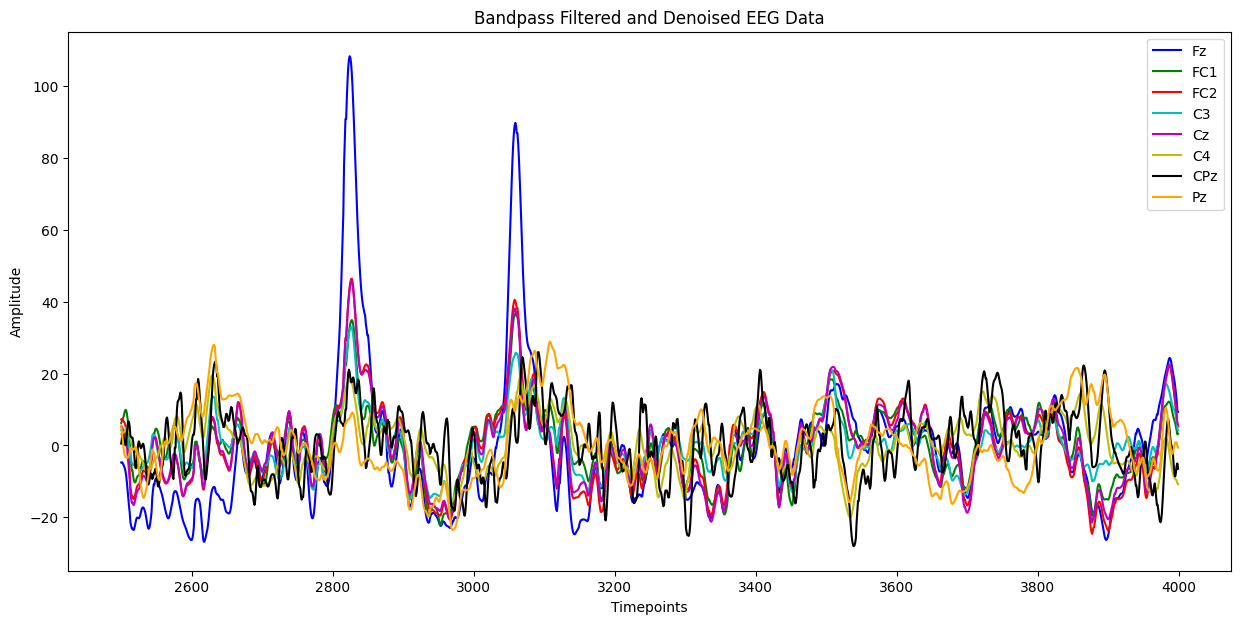

In [169]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt

channel_names = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CPz', 'Pz']
# Bandpass filter parameters
lowcut = 0.3
highcut = 40
fs = 250  # Sampling frequency

# Apply the bandpass filter to the first eight channels
filtered_data = np.apply_along_axis(butter_bandpass_filter, 0, final_eeg_data[:, :8], lowcut, highcut, fs)

# Convert filtered data to DataFrame
filtered_data_df = pd.DataFrame(filtered_data, columns=channel_names)

# Denoise the filtered data
n_clusters = [10] * len(channel_names)
denoised_data_df = denoise_data(filtered_data_df, col_names=channel_names, n_clusters=n_clusters)
denoised_data_inst = np.concatenate((denoised_data_df, last_four_columns), axis=1)

# Define a list of colors for the plot, one for each channel
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange']

plt.figure(figsize=(15, 7))
for i, channel in enumerate(channel_names):
    plt.plot(denoised_data_df.iloc[2500:4000][channel], color=colors[i], label=channel)
plt.legend()
plt.title('Bandpass Filtered and Denoised EEG Data')
plt.xlabel('Timepoints')
plt.ylabel('Amplitude')
plt.show()



In [161]:
denoised_data_df.shape

(124000, 8)

In [162]:
import numpy as np

# Extract the labels from the ninth column (fourth from the right)
labels = denoised_data_inst[:, -4]

# Filter the rows where the label is 'b'
rows_with_label_b = denoised_data_inst[labels == 'b']

# Calculate the mean of the first 8 columns (EEG channels) for these rows
mean_values = rows_with_label_b[:, :8].mean(axis=0) 

# mean_values will contain the mean of each of the 8 EEG channels for the rows labeled 'b'
# print(mean_values)
# mean_values.shape

In [163]:
normalized_data_inst = denoised_data_inst.copy()
normalized_data_inst[:, :8] = denoised_data_inst[:, :8] - mean_values
normalized_data_inst.shape

(124000, 12)

Creating RawArray with float64 data, n_channels=8, n_times=80000
    Range : 0 ... 79999 =      0.000 ...   319.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components
 


C:\Users\Maryam\AppData\Local\Temp\ipykernel_26364\3515787077.py:40: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 11.3s.
Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


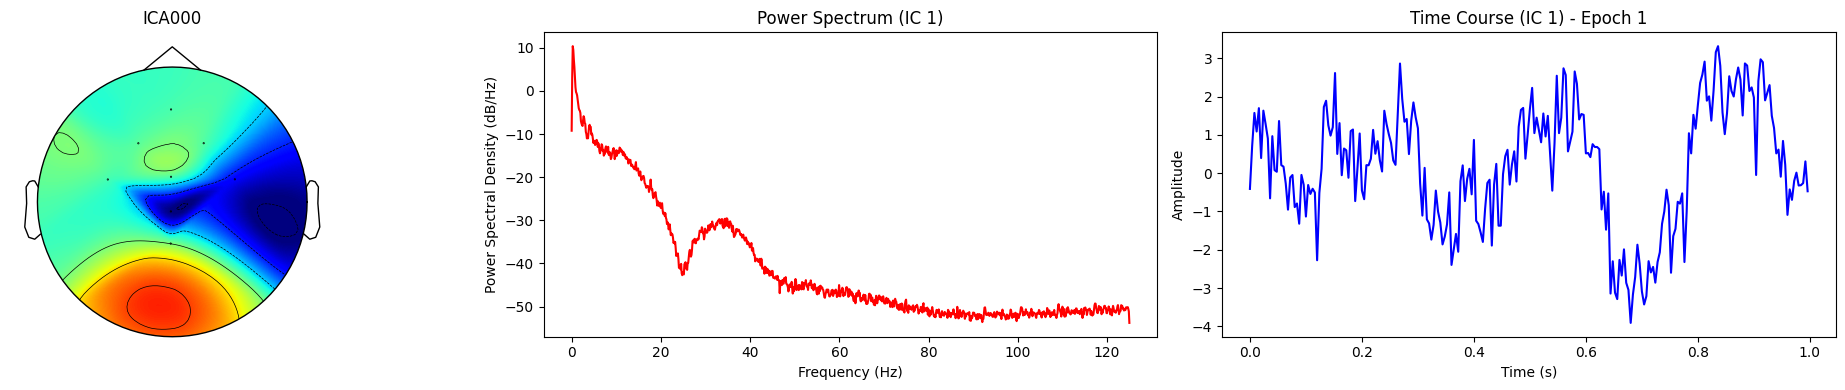

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


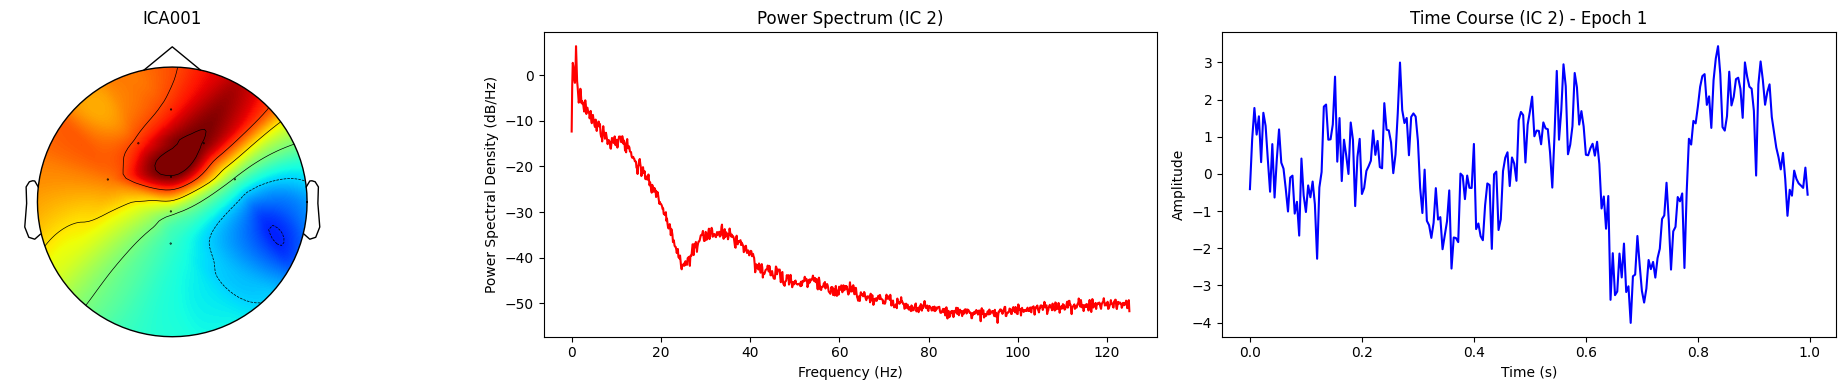

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


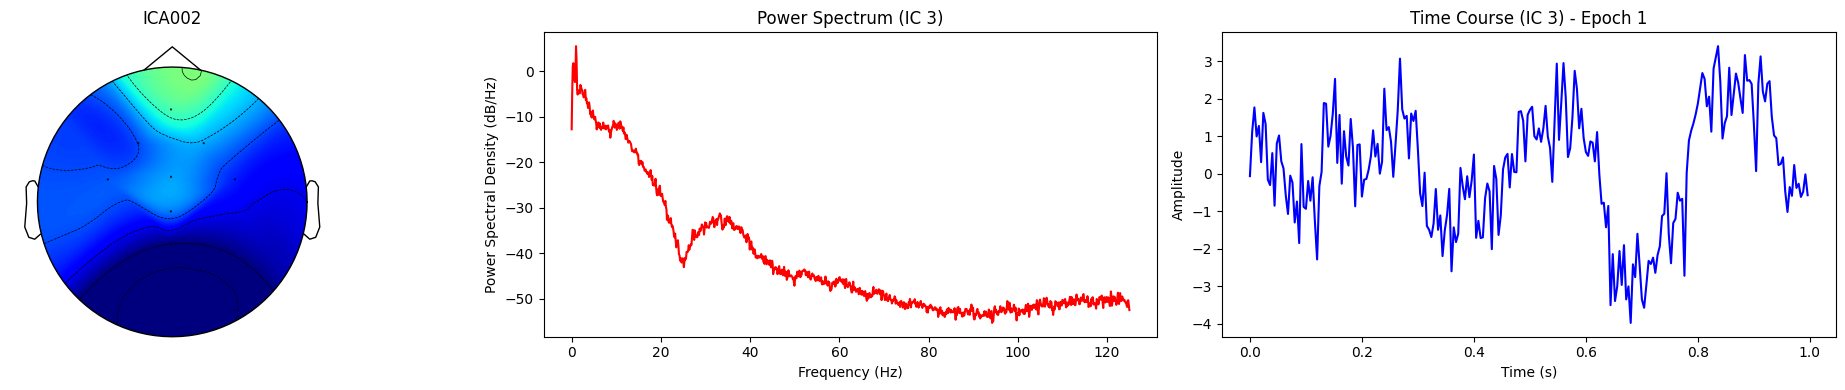

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


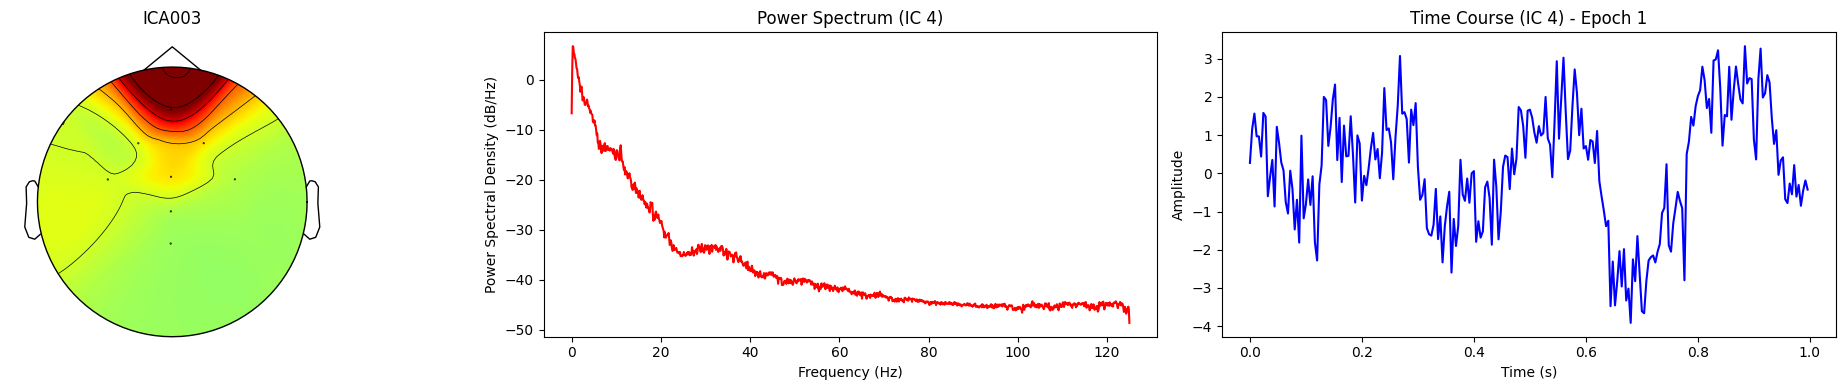

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


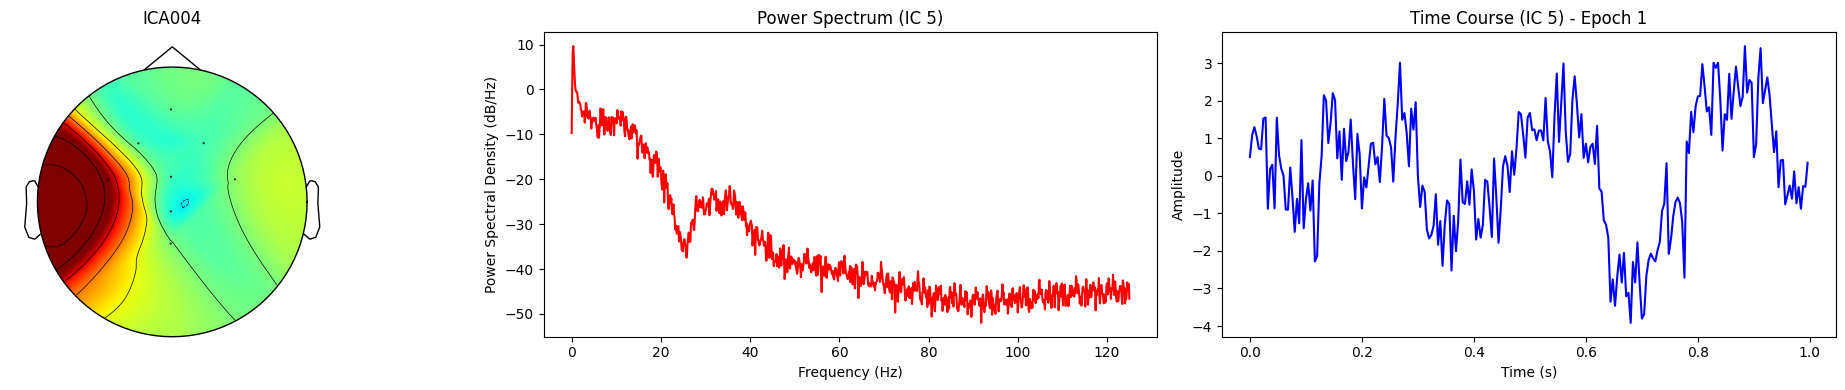

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


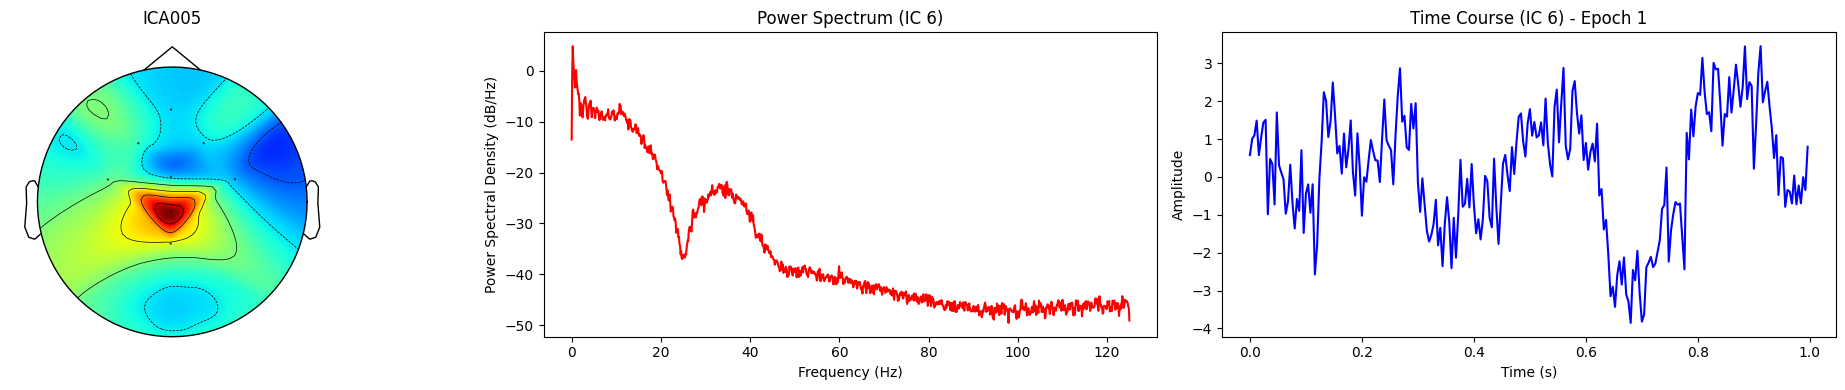

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


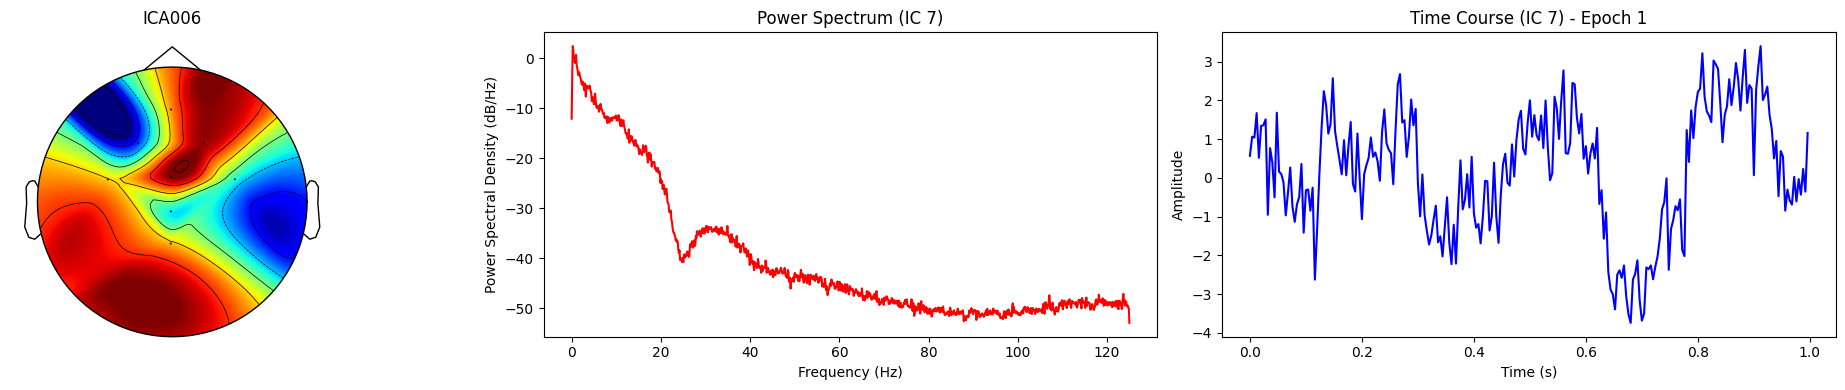

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


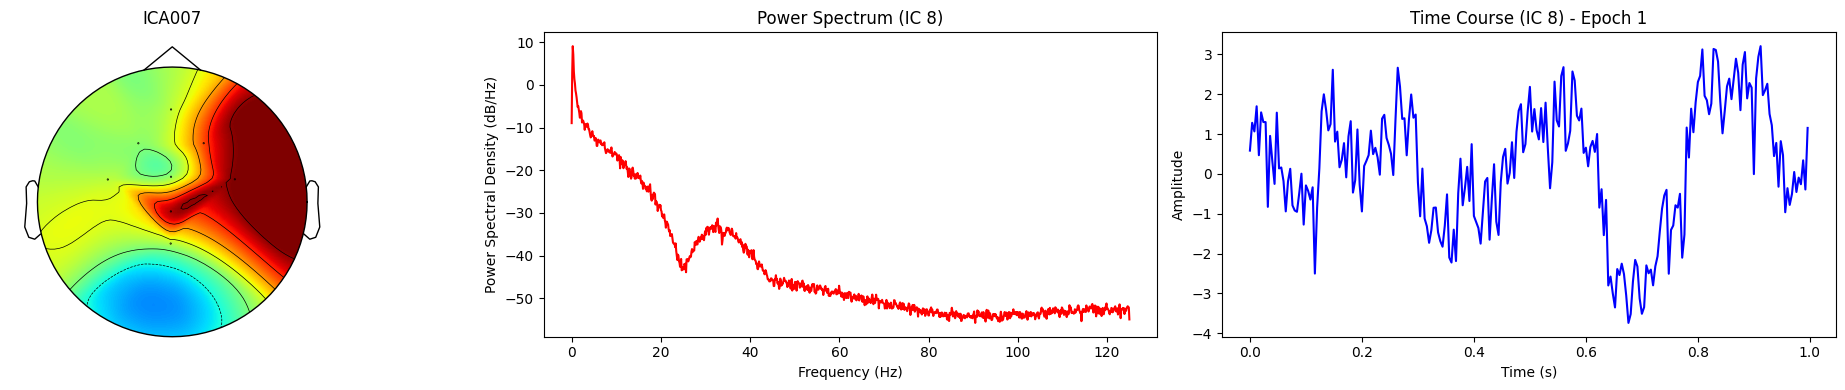

In [166]:
import mne
from mne.preprocessing import ICA
import numpy as np
import matplotlib.pyplot as plt

# Placeholder for your data loading mechanism
# normalized_data_inst should be a numpy array with the shape of (124000, 12)
# Load your preprocessed and baseline corrected data into 'normalized_data_inst'
# normalized_data_inst = np.load('path_to_your_data.npy')

# Constants
n_samples_per_epoch = 250  # 250 samples per epoch (1 second epochs at 250 Hz)
sfreq = 250  # Sampling frequency
selected_channels = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CPz', 'Pz']
main_trial_labels = ['F', 'M', 'I', 'O']  # Main trial labels: , 'g', 'b', 'pw', 'inst'

# Extract epochs
n_epochs = denoised_data_inst.shape[0] // n_samples_per_epoch
epochs =denoised_data_inst[:n_epochs * n_samples_per_epoch, :8].reshape(n_epochs, n_samples_per_epoch, 8)
labels = denoised_data_inst[::n_samples_per_epoch, 8]  # Labels are in the ninth column

# Select epochs corresponding to main trials
main_trial_epochs = epochs[np.isin(labels, main_trial_labels)]

# Concatenate epochs along the time axis for ICA
concatenated_epochs = main_trial_epochs.reshape(-1, main_trial_epochs.shape[2])

# Create the MNE info structure
info = mne.create_info(ch_names=selected_channels, sfreq=sfreq, ch_types='eeg')

# Set the standard 10-20 montage, which includes the selected channels
montage = mne.channels.make_standard_montage('standard_1020')
info.set_montage(montage)

# Create RawArray with the concatenated epochs
raw = mne.io.RawArray(concatenated_epochs.T, info)

# Initialize and fit Infomax ICA
ica = ICA(n_components=8, random_state=0, method='infomax')
ica.fit(raw)

# Transform the original EEG data into the source space
source_data = ica.get_sources(raw).get_data()

# Now, source_data contains the time courses of the independent components
# We can reshape it back to the original epoch structure
source_epochs = source_data.reshape(-1, n_samples_per_epoch, ica.n_components_)

# Plot the results for each component
for i in range(ica.n_components_):
    # Create figure and axes
    fig, axes = plt.subplots(1, 3, figsize=(20, 4))

    # Plot the spatial pattern of the IC on the scalp (topomap)
    ica.plot_components(picks=i, show=False, axes=axes[0], cmap='jet')

    # Plot the power spectrum of the IC
    # psd, freqs = mne.time_frequency.psd_array_welch(source_epochs[:, :, i].reshape(-1), sfreq, n_fft=2048)
    psd, freqs = mne.time_frequency.psd_array_welch(ica.get_sources(raw).get_data()[i], sfreq, n_fft=2048)
    axes[1].plot(freqs, 10 * np.log10(psd), color='red')
    axes[1].set_title(f'Power Spectrum (IC {i+1})')
    axes[1].set_xlabel('Frequency (Hz)')
    axes[1].set_ylabel('Power Spectral Density (dB/Hz)')

    # Plot the time course for the first epoch of the i-th component
    component_time_course = source_epochs[0, :, i]
    axes[2].plot(np.arange(n_samples_per_epoch) / sfreq, component_time_course, color='blue')
    axes[2].set_title(f'Time Course (IC {i+1}) - Epoch 1')
    axes[2].set_xlabel('Time (s)')
    axes[2].set_ylabel('Amplitude')

    # Show the figure
    plt.tight_layout()
    plt.show()


In [112]:
concatenated_epochs.shape

(124000, 8)

Creating RawArray with float64 data, n_channels=8, n_times=124000
    Range : 0 ... 123999 =      0.000 ...   495.996 secs
Ready.


c:\Users\Maryam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


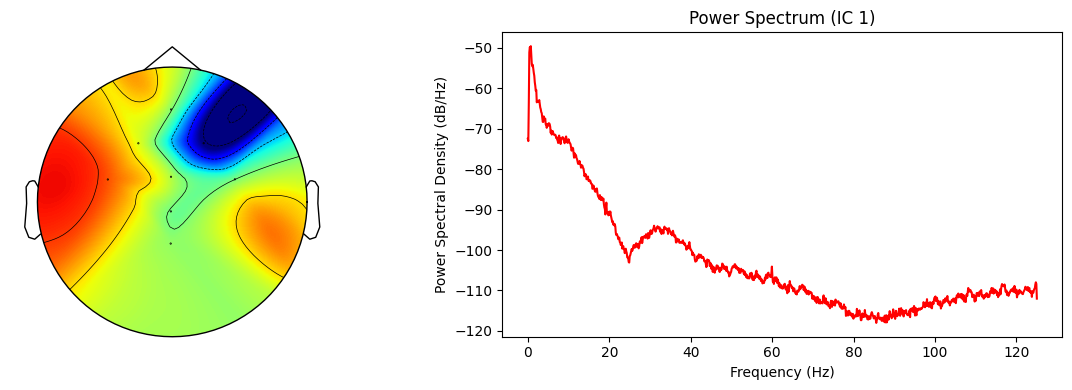

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


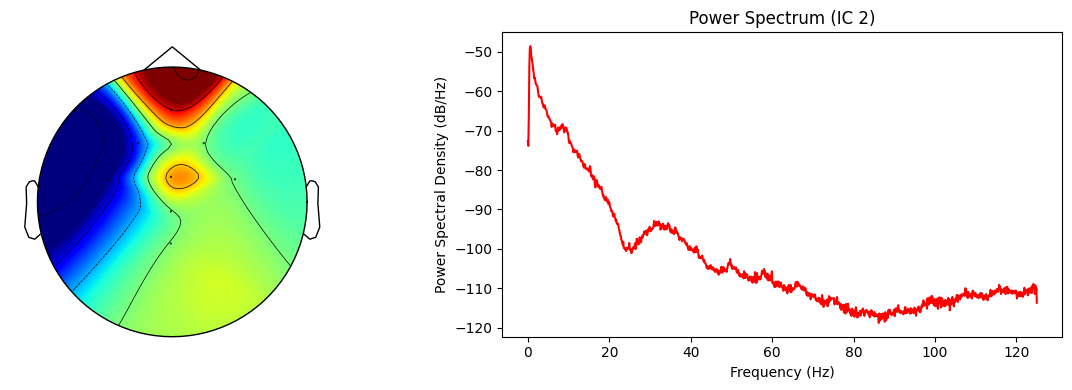

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


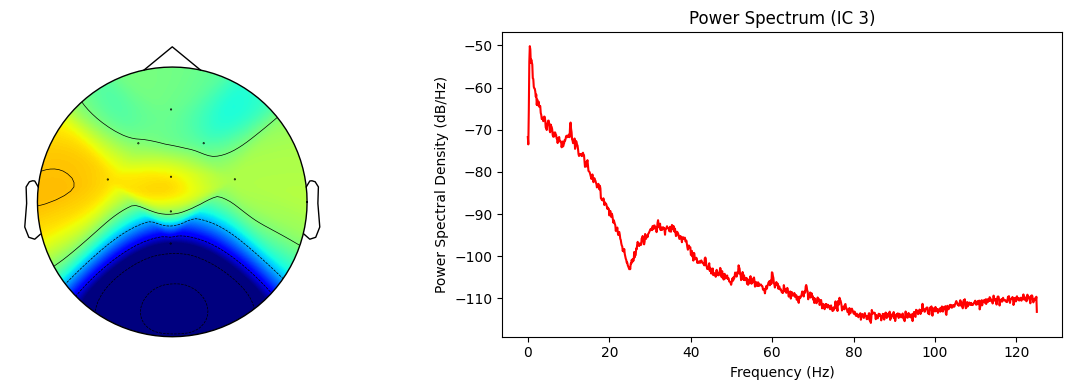

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


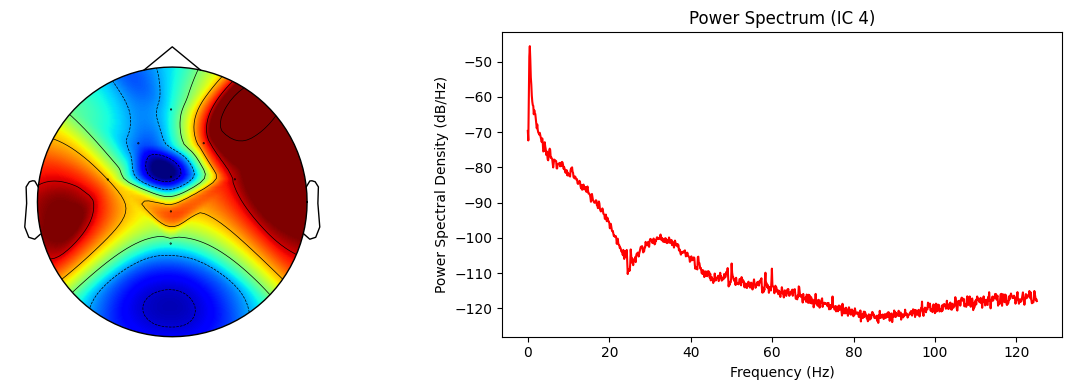

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


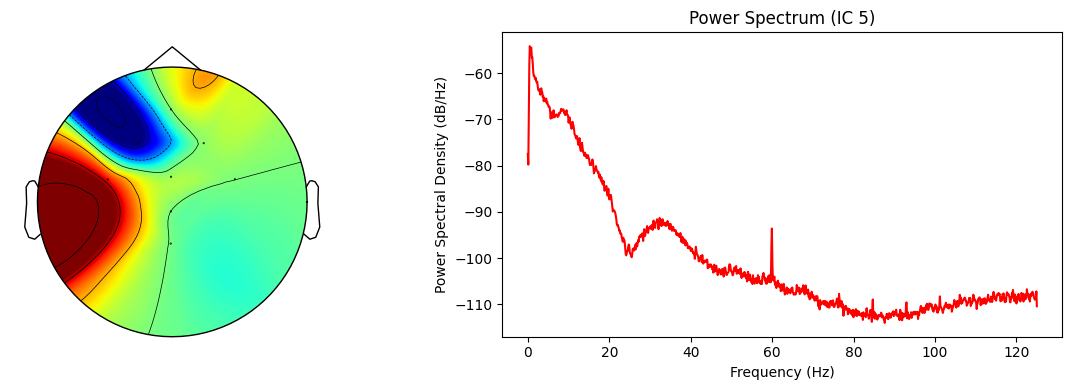

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


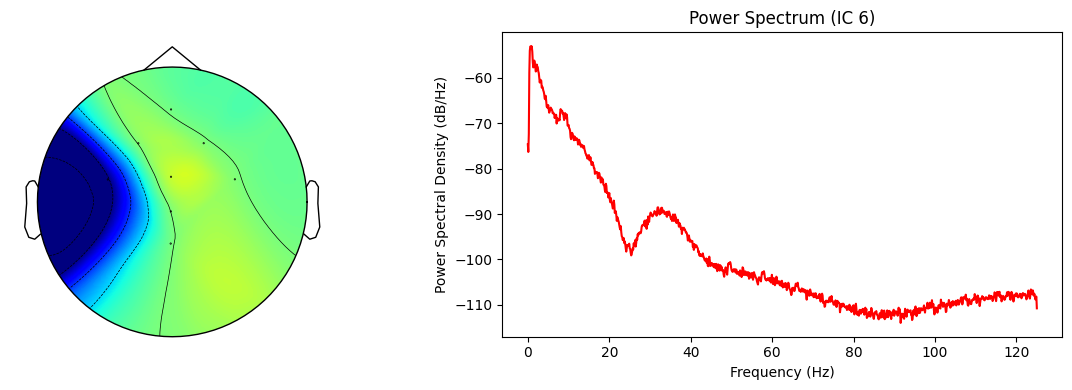

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


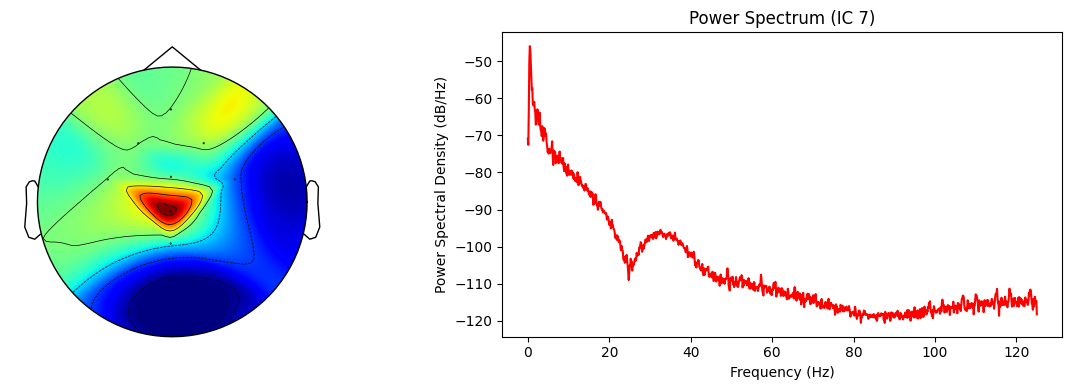

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


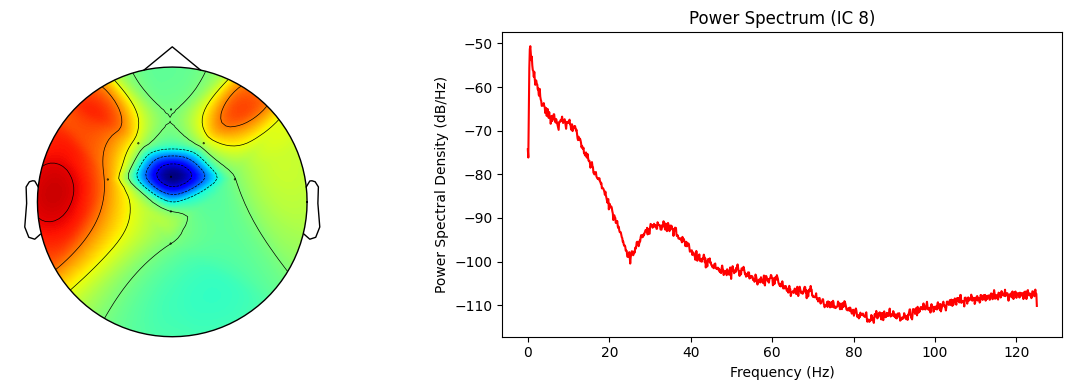

In [93]:
import mne
from mne.preprocessing import ICA
from sklearn.decomposition import FastICA
import numpy as np
import matplotlib.pyplot as plt

# Define the sampling frequency and the channel names
sfreq = 250  # Sampling frequency
selected_channels = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CPz', 'Pz']

# Create the MNE info structure
info = mne.create_info(ch_names=selected_channels, sfreq=sfreq, ch_types='eeg')

# Set the standard 10-20 montage, which includes the selected channels
montage = mne.channels.make_standard_montage('standard_1020')
info.set_montage(montage)

# Create the RawArray with the first 8 channels of EEG data
raw_data = normalized_data_inst[:, :8].T  # Replace with your actual data
raw = mne.io.RawArray(raw_data, info)

# Initialize FastICA from sklearn
fast_ica = FastICA(n_components=8, random_state=0)

# Fit the ICA model to the data
S_ = fast_ica.fit_transform(raw.get_data().T)  # Reconstruct signals. Transpose data to fit (samples, features)
A_ = fast_ica.mixing_  # Get estimated mixing matrix

# The unmixing matrix is the inverse of the mixing matrix
unmixing_matrix = np.linalg.pinv(A_)

# Prepare an MNE ICA object
ica = ICA(n_components=8, random_state=0, method='fastica')
ica.unmixing_matrix_ = unmixing_matrix
ica.mixing_matrix_ = A_
ica.pca_mean_ = fast_ica.mean_
ica.n_components_ = A_.shape[1]
ica.ch_names = selected_channels
ica.pre_whitener_ = np.ones((ica.n_components_, 1))
ica.info = info

# Now we'll set up the ICA components (topomaps)
ica.components_ = unmixing_matrix.T

# Plotting the components
for i in range(ica.n_components_):
    # Create a figure with two subplots: one for the topomap, one for the spectrum
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Plot the topomap
    mne.viz.plot_topomap(ica.components_[:, i], ica.info, axes=ax[0], show=False, cmap='jet')

    # Calculate the PSD for the component and plot it
    psd, freqs = mne.time_frequency.psd_array_welch(S_[:, i], sfreq, n_fft=2048)
    ax[1].plot(freqs, 10 * np.log10(psd), color='red')
    ax[1].set_xlabel('Frequency (Hz)')
    ax[1].set_ylabel('Power Spectral Density (dB/Hz)')
    ax[1].set_title(f'Power Spectrum (IC {i+1})')

    # Show the plot
    plt.tight_layout()
    plt.show()


Creating RawArray with float64 data, n_channels=8, n_times=124000
    Range : 0 ... 123999 =      0.000 ...   495.996 secs
Ready.


c:\Users\Maryam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


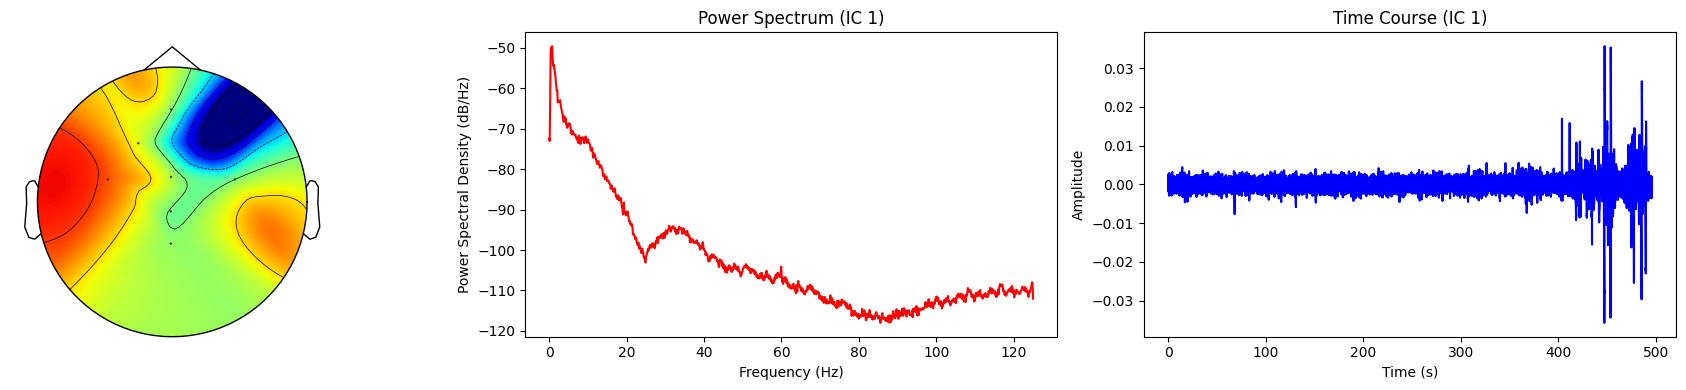

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


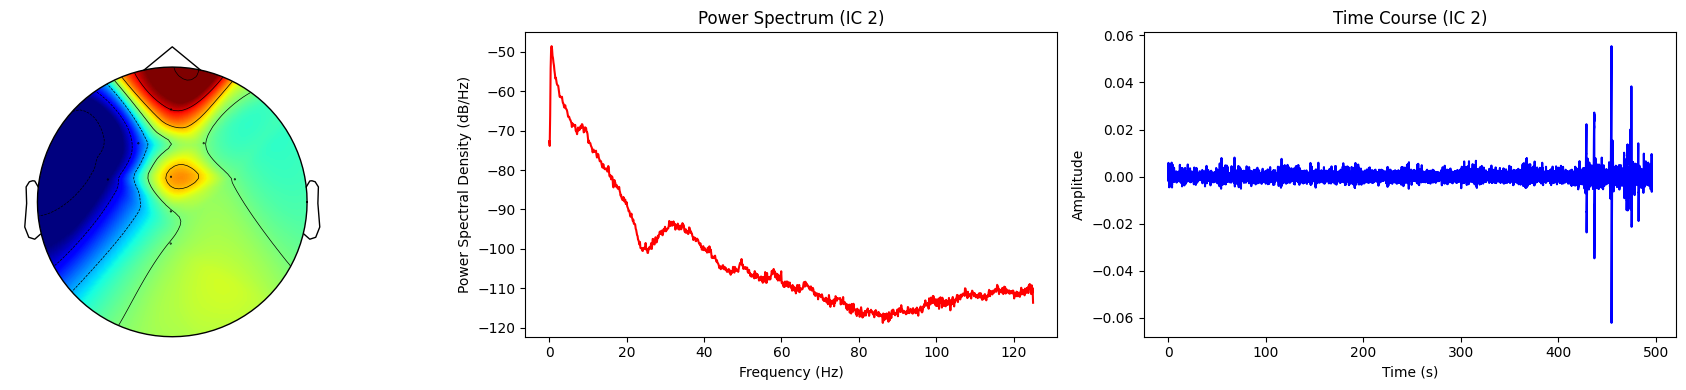

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


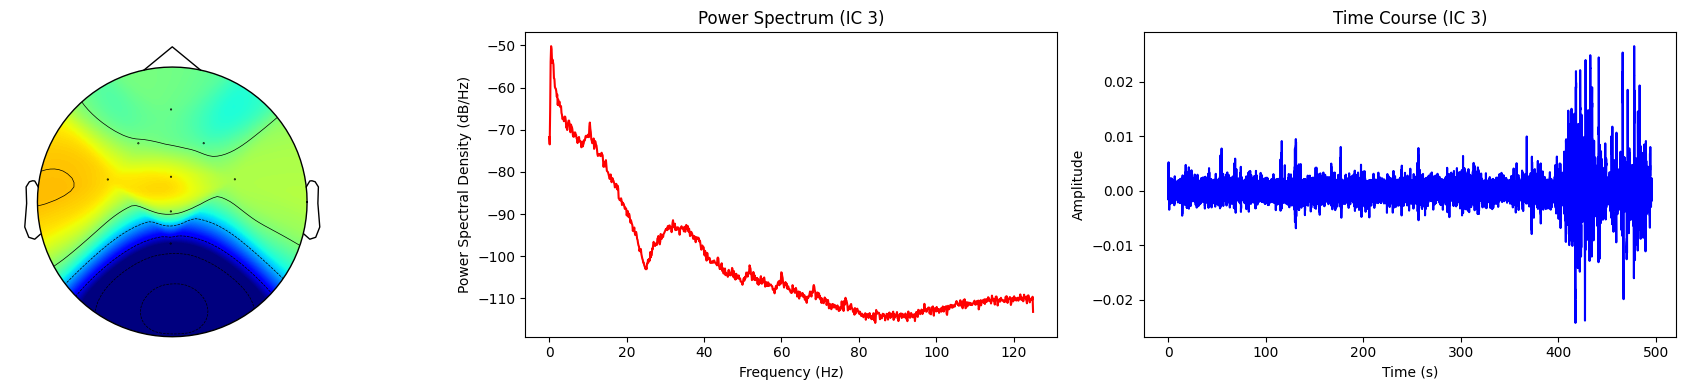

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


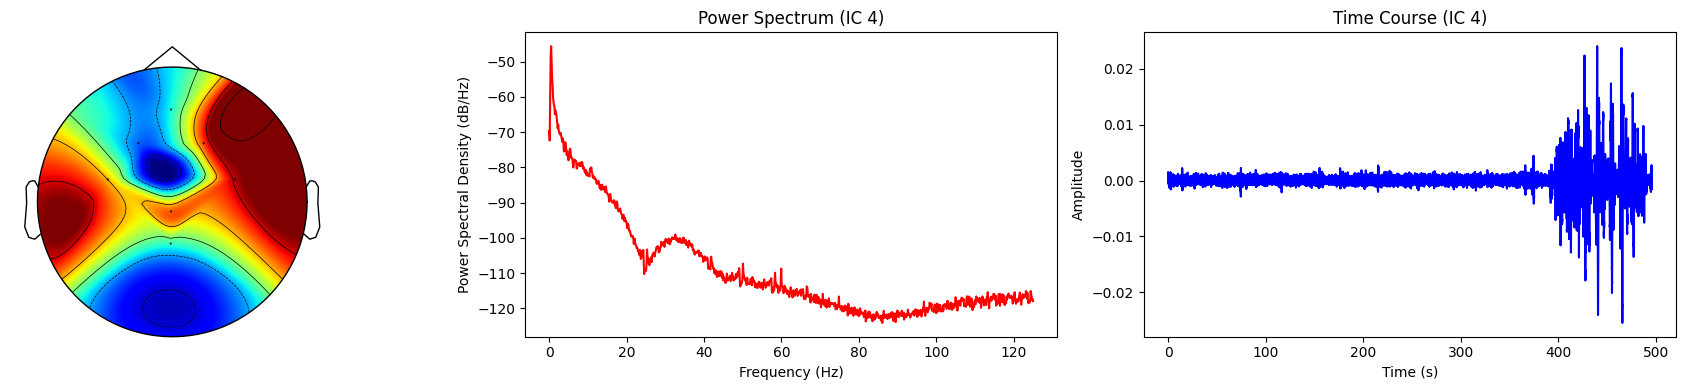

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


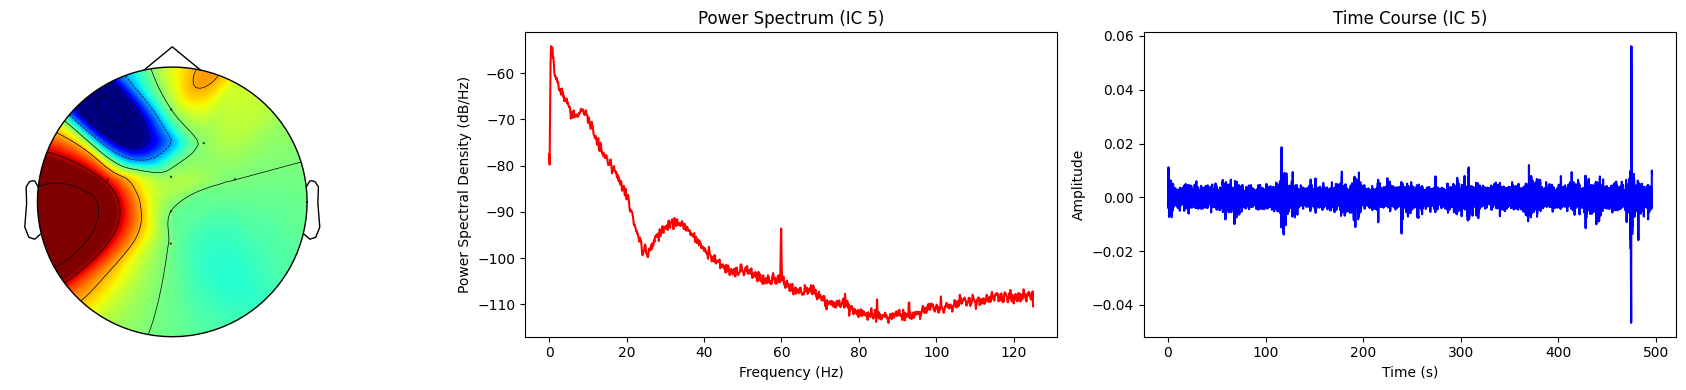

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


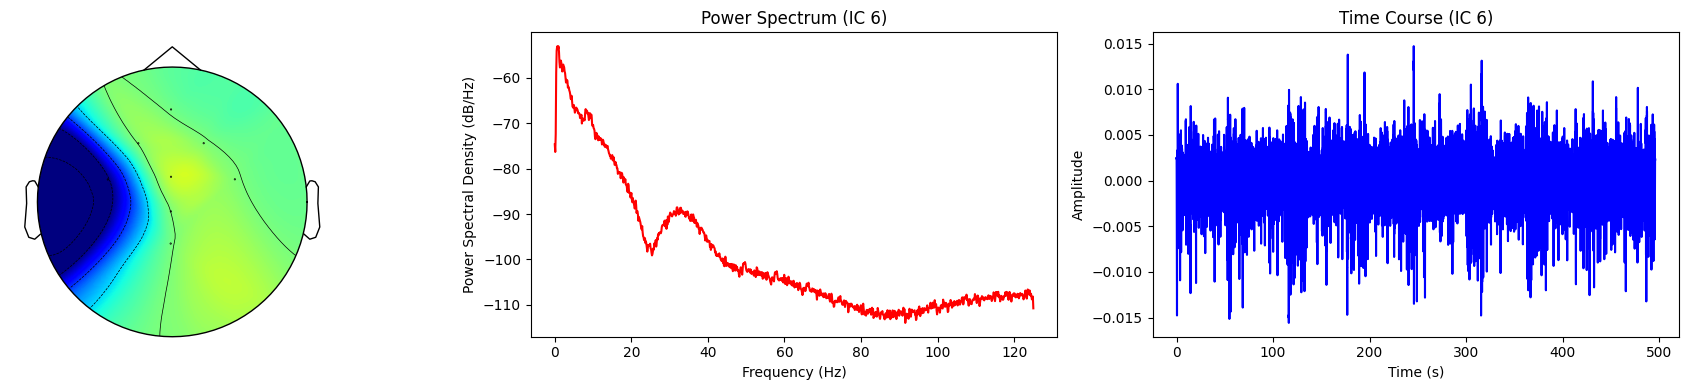

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


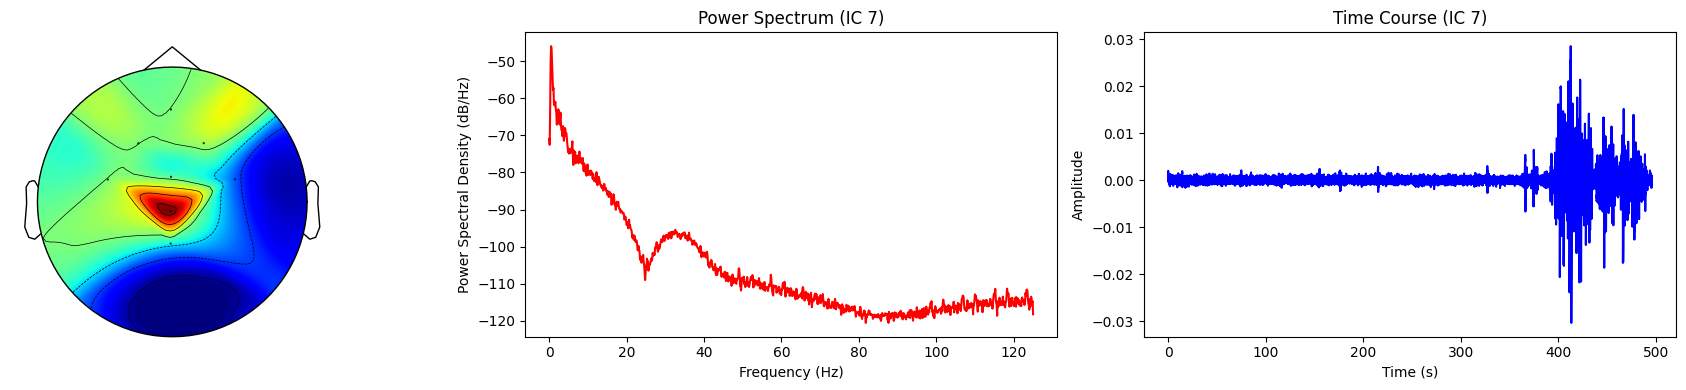

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


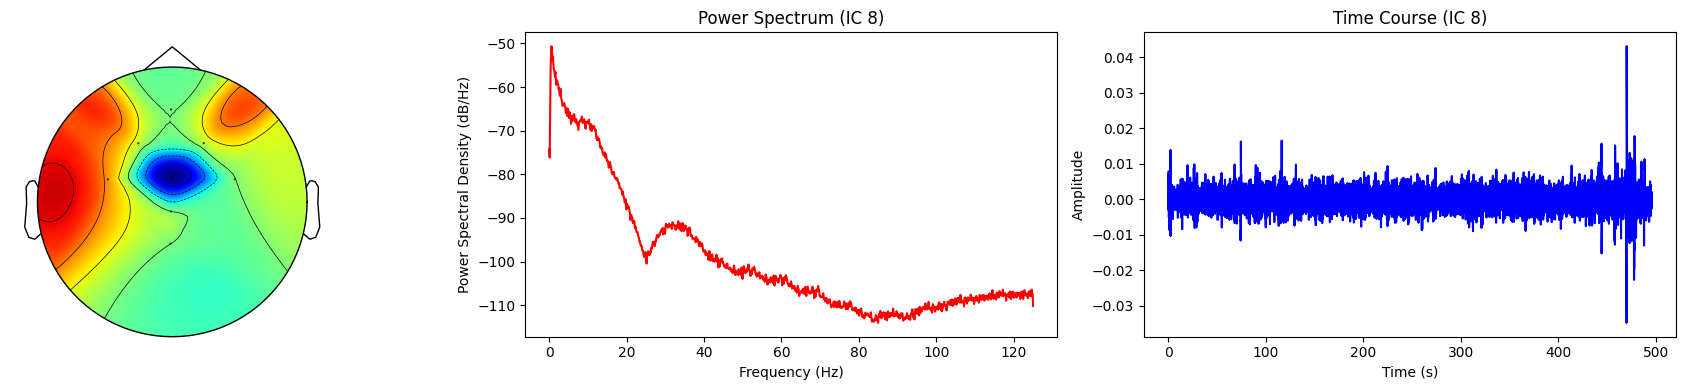

In [94]:
import mne
from mne.preprocessing import ICA
from sklearn.decomposition import FastICA
import numpy as np
import matplotlib.pyplot as plt

# Assuming normalized_data_inst is your preprocessed and baseline corrected data
# Replace with your actual data
# Example: normalized_data_inst = np.load('path_to_your_data.npy')

# Define the sampling frequency and the channel names
sfreq = 250  # Sampling frequency
selected_channels = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CPz', 'Pz']

# Create the MNE info structure
info = mne.create_info(ch_names=selected_channels, sfreq=sfreq, ch_types='eeg')

# Set the standard 10-20 montage, which includes the selected channels
montage = mne.channels.make_standard_montage('standard_1020')
info.set_montage(montage)

# Create the RawArray with the first 8 channels of EEG data
raw_data = normalized_data_inst[:, :8].T  # Replace with your actual data
raw = mne.io.RawArray(raw_data, info)

# Initialize FastICA from sklearn
fast_ica = FastICA(n_components=8, random_state=0)

# Fit the ICA model to the data
S_ = fast_ica.fit_transform(raw.get_data().T)  # Reconstruct signals. Transpose data to fit (samples, features)
A_ = fast_ica.mixing_  # Get estimated mixing matrix

# The unmixing matrix is the inverse of the mixing matrix
unmixing_matrix = np.linalg.pinv(A_)

# Prepare an MNE ICA object
ica = ICA(n_components=8, random_state=0, method='fastica')
ica.unmixing_matrix_ = unmixing_matrix
ica.mixing_matrix_ = A_
ica.pca_mean_ = fast_ica.mean_
ica.n_components_ = A_.shape[1]
ica.ch_names = selected_channels
ica.pre_whitener_ = np.ones((ica.n_components_, 1))
ica.info = info

# Set up the ICA components (topomaps)
ica.components_ = unmixing_matrix.T

# Plotting the components
for i in range(ica.n_components_):
    # Create a figure with three subplots: topomap, power spectrum, and time course
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))

    # Plot the topomap
    mne.viz.plot_topomap(ica.components_[:, i], ica.info, axes=ax[0], show=False, cmap='jet')

    # Calculate the PSD for the component and plot it
    psd, freqs = mne.time_frequency.psd_array_welch(S_[:, i], sfreq, n_fft=2048)
    ax[1].plot(freqs, 10 * np.log10(psd), color='red')
    ax[1].set_xlabel('Frequency (Hz)')
    ax[1].set_ylabel('Power Spectral Density (dB/Hz)')
    ax[1].set_title(f'Power Spectrum (IC {i+1})')

    # Plot the time course
    times = np.arange(S_.shape[0]) / sfreq
    ax[2].plot(times, S_[:, i], color='blue')
    ax[2].set_xlabel('Time (s)')
    ax[2].set_ylabel('Amplitude')
    ax[2].set_title(f'Time Course (IC {i+1})')

    # Show the plot
    plt.tight_layout()
    plt.show()


In [45]:
folder_name = 'BA_1'
selected_columns = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CPz', 'Pz']
# Define a list of colors, can be extended or modified
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink', 'brown', 'gray']
duration = 40 
raw=[]
event=[]
PP=[]
BP=[]
cleaned_data_list = []
cleaned_smothed_list = []
if os.path.exists(folder_name) and os.path.isdir(folder_name):
    for file_name in os.listdir(folder_name):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_name, file_name)
            s_temp = pd.read_csv(file_path, header=None)
            inst = s_temp.iloc[:, 17]
            df_temp = s_temp.iloc[:, :8]
            # print(df_temp.shape)
            # df_temp.plot(figsize=(10, 8))
            # plt.show()
            raw.append(df_temp)
            print(len(raw))
            event.append(inst)
    raw_np=np.array(raw)
        
        # plt.plot(raw)
        # plt.show()
            
        # # 1. Band Pass
        # raw_bp = np.copy(raw)
        # for column in range(8):
        #     raw_bp[:, column] = butter_bandpass_filter(raw_bp[:, column], lowcut=.4, highcut=40, fs=250) 
        # # plt.plot(raw_bp)
        # # plt.show()
            
        # # Denoise the cleaned data
        # raw_bp_df = pd.DataFrame(raw_bp, columns=selected_columns)
        # n_clusters = [10]*len(selected_columns)  # adjust the values based on how much smoothing you want
        # denoised_data_df = denoise_data(raw_bp_df, col_names=selected_columns, n_clusters=n_clusters)
        # plt.plot(denoised_data_df)
        # plt.show()

        # # 2. Create MNE Raw object
        # info = mne.create_info(ch_names=selected_columns, ch_types=['eeg']*8, sfreq=250)
        # raw_mne = mne.io.RawArray(denoised_data_df.T, info)
        # raw_mne.set_montage(montage)
        # times = raw_mne.times
            
        # fig, axs = plt.subplots(len(selected_columns), 1, figsize=(5, 10), sharex=True)
        # for i, channel in enumerate(selected_columns):
        #     axs[i].plot(times, raw_bp[:, i], label=channel, color=colors[i])
        #     axs[i].set_title(channel)
        #     axs[i].legend(loc="upper right")
        # plt.xlabel('Time (s)')
        # plt.tight_layout()
        # plt.suptitle(f'raw_bp for Trial {file_name}', y=1.02)
        # plt.show()
            
   
        # fig, axs = plt.subplots(len(selected_columns), 1, figsize=(5, 10), sharex=True)
        # for i, channel in enumerate(selected_columns):
        #     axs[i].plot(times, denoised_data_df[channel], label=channel, color=colors[i])
        #     axs[i].set_title(channel)
        #      axs[i].legend(loc="upper right")
        # plt.xlabel('Time (s)')
        # plt.tight_layout()
        # plt.suptitle(f'Denoised EEG Data for Trial {file_name}', y=1.02)
        # plt.show()
            
            

            


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


C:\Users\Maryam\AppData\Local\Temp\ipykernel_26364\1043094276.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  raw_np=np.array(raw)


In [46]:
raw_np.shape

(24,)

In [ ]:
                        
            # 2. Create MNE Raw object
            info = mne.create_info(ch_names=selected_columns, ch_types=['eeg']*8, sfreq=250)
            raw_mne = mne.io.RawArray(denoised_data_df.T, info)
            raw_mne.set_montage(montage)
            times = raw_mne.times
            
                        satisfied_with_ica = False 
            while not satisfied_with_ica: 
            
                # 3. Apply ICA
                ica = ICA(n_components=8, method='infomax', fit_params=dict(extended=True), random_state=None, max_iter=800)
                ica.fit(raw_mne, picks='eeg')
            
                # After getting ICA sources:
                sources = ica.get_sources(raw_mne)
                source_data = sources.get_data()
                # Define the sampling frequency and parameters for the Welch method
                
                fs = 250  # Your data's sampling frequency
                nperseg = fs  # 1-second window
                noverlap = nperseg // 2  # 50% overlap

                # Create a figure to encapsulate all plots for this trial/block
                n_components = source_data.shape[0]
                fig, axes = plt.subplots(n_components, 3, figsize=(8, n_components*1.5))
                fig.suptitle(f'Trial_{file_name}', fontsize=10)

                for i in range(n_components):
                    # Topomap
                    mne.viz.plot_topomap(ica.get_components()[:, i], ica.info, axes=axes[i, 0], cmap='jet', show=False, sphere=0.08)    
                    # Time Course
                    axes[i, 1].plot(raw_mne.times, source_data[i, :])
                    axes[i, 1].set_title(f'Component {i} Time Course')
                    axes[i, 1].set_xlabel('Time (s)')
                    axes[i, 1].set_ylabel('Amplitude')
                    # PSD
                    frequencies, psd = welch(source_data[i, :], fs=fs, nperseg=nperseg)
                    mask = (frequencies >= 0) & (frequencies <= 40)
                    psd_log = 10 * np.log10(psd[mask])
                    axes[i, 2].plot(frequencies[mask], psd_log)
                    axes[i, 2].set_title(f'Component {i} PSD')
                    axes[i, 2].set_xlabel('Frequency (Hz)')
                    axes[i, 2].set_ylabel('PSD (dB/Hz)')
                plt.tight_layout()
                plt.subplots_adjust(top=0.95)
                plt.show()
                # Prompt user for components to exclude
                exclude_components_input = input("Enter components to remove as comma-separated values (e.g., 0,2,5). If none, just press Enter: ")

                if exclude_components_input.strip():  # Check if the input is not empty
                    exclude_components = [int(comp.strip()) for comp in exclude_components_input.split(",")]
                    # Mark components for exclusion
                    ica.exclude = exclude_components
                    # Apply ICA cleaning
                    raw_mne_clean = raw_mne.copy()
                    ica.apply(raw_mne_clean)
                else:
                    print("No components excluded. Proceeding with the original data.")
                    raw_mne_clean = raw_mne.copy()

                # Extract the data and times from the cleaned raw object
                clean_data = raw_mne_clean.get_data().T
                times = raw_mne_clean.times

                fig, axs = plt.subplots(len(selected_columns), 2, figsize=(10, 10), sharex=True)

                for i, channel in enumerate(selected_columns):
                    axs[i,1].plot(times, denoised_data_df[channel], label=f"{channel} (Raw)", color='gray', linestyle='--')
                    axs[i,1].plot(times, clean_data[:, i], label=f"{channel} (Cleaned)", color='b')
                    axs[i,1].legend(loc="upper right")
                    axs[i,1].set_title(channel)            
                    axs[i,0].plot(times, clean_data[:, i], label=f"{channel} (Cleaned)", color=colors[i])
                    axs[i,0].set_title(channel)
                plt.xlabel('Time (s)')
                plt.tight_layout()
                plt.suptitle(f'Cleaned vs Raw EEG Data for Trial {file_name}', y=1.02)
                plt.show()
                
                # Ask the user if they're satisfied with the applied ICA
                user_response = input("Are you satisfied with the applied ICA? (Y/N): ").strip().upper()

                if user_response == 'Y':
                    satisfied_with_ica = True  # Update satisfaction flag to exit the inner loop
                    cleaned_data_list.append(denoised_data_df)
                    # cleaned_smothed_list.append(BP_artifact_RJ_SM)
                elif user_response == 'N':
                    # Do not update the satisfaction flag, so the inner loop will restart
                    print("Reapplying ICA for the current data.")
                else:
                    print("Invalid input. Please enter 'Y' or 'N'.")